# Logistic Regression

## Data Preprocessing

In [64]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict

# Set working directory
month_file = '2_June'
# Set working directory
os.chdir("/Users/mau/Library/CloudStorage/Dropbox/Mac/Documents/Dissertation/Chapter 2/Entire_Data/By month/"+month_file+"/Ending Balances/Per_Player")

In [65]:
# Filter Columns
filter = ['session_time', 'gender', 'age_gen', 'day', 'timeofday', 'first_outcome',
        'first_wager','first_p/b', 'last_outcome', 'last_wager', 'last_p/b',
        'beginning_amt', 'ending_amt', 'ending_balance', 'ave_slotdenom', 
        'std_slotdenom', 'min_slotdenom', 'max_slotdenom', 'ave_theo_payback',
        'min_theo_payback', 'max_theo_payback', 'ave_wageramt', 'std_wageramt',
        'min_wager', 'max_wager', 'ave_p/b', 'std_p/b', 'max_p/b', 'max_profit', 'depletion_slope', 
        '#inc_slotdenom', '#dec_slotdenom', '#inc_maxbet', '#dec_maxbet',
        'w/min', 'l/min', 'nh/min', 'd/min', '2ws_profit', '2ws_wgramt','2ws/min', 
        '3ws_profit', '3ws_wgramt', '3ws/min', '4ws_profit', '4ws_wgramt', '4ws/min', 
        'w/g', 'l/g', 'nh/g', 'd/g', 'ave_time_per_gamble',
        'min_time_per_gamble', 'machines_changes', 'unique_machines', 'classification']

# Taking out ave_time_per_machine and max_time_per_gamble

# Load dataset
dataset = pd.read_parquet('top_vs_ntop_player_ending_balance_by_session.parquet', columns=filter)

# Keep only session_time 1
dataset = dataset[dataset['session_time'] == 1]
# Drop age_range and playerkey
dataset = dataset.drop(['session_time'], axis=1)

## Load Dataframes

In [66]:
# Convert 'ave_time_per_machine' to seconds
# dataset['ave_time_per_machine'] = dataset['ave_time_per_machine'].dt.total_seconds()

# # Seperate dependent and independent variables
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Econde gender column (Binary)
le = LabelEncoder()

# Binary Encode gender and simplay
X[:, 0] = le.fit_transform(X[:, 0])

# # Encode age_generartion, day, time of day,  and time of day columns, first_outcome, and last_outcome.
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1, 2, 3, 4, 7])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

y = le.fit_transform(y)

## Handling Class Imbalance 
# Apply SMOTE - SMOTE generates synthetic samples for the minority class to balance the dataset:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled , test_size = 0.2, random_state = 1)

sc = StandardScaler()

# Scale all columns except the encoded ones
X_train[:, 19:] = sc.fit_transform(X_train[:, 19:])
X_test[:, 19:] = sc.transform(X_test[:, 19:])


classifier = LogisticRegression(random_state = 0, max_iter=1000)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average='macro', zero_division=1))
print('Recall: ', recall_score(y_test, y_pred, average='macro'))
print('F1 Score: ', f1_score(y_test, y_pred, average='macro'))

[[31  5]
 [ 2 58]]
Accuracy:  0.9270833333333334
Precision:  0.93001443001443
Recall:  0.913888888888889
F1 Score:  0.9208200777659952


## Cumulative Accuracy Profile (CAP) Graph

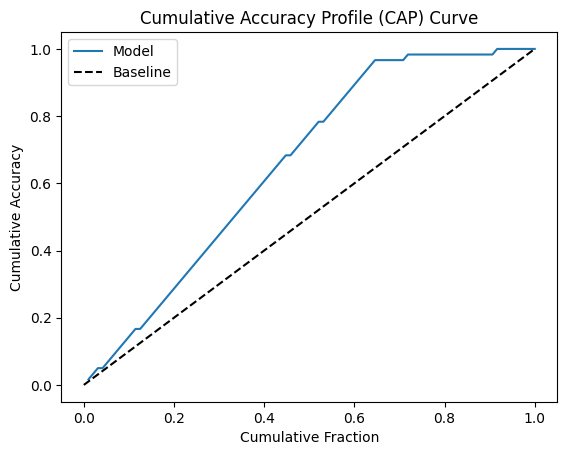

In [67]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the predicted probabilities or scores named 'predicted_scores' and true labels named 'true_labels'

# Sort the scores and corresponding true labels
sorted_indices = np.argsort(y_pred)[::-1]
sorted_true_labels = y_test[sorted_indices]

# Calculate cumulative metrics
total_positive = np.sum(y_test)
cumulative_positives = np.cumsum(sorted_true_labels)
cumulative_accuracy = cumulative_positives / total_positive
cumulative_fraction = np.arange(1, len(sorted_true_labels) + 1) / len(sorted_true_labels)

# Create the CAP curve plot
plt.plot(cumulative_fraction, cumulative_accuracy, label='Model')
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
plt.xlabel('Cumulative Fraction')
plt.ylabel('Cumulative Accuracy')
plt.title('Cumulative Accuracy Profile (CAP) Curve')
plt.legend()
plt.show()

## Hyperparameter Tuning

In [52]:
# Define hyperparameters for tuning
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Penalty (L1 or L2)
    'solver': ['liblinear', 'saga'],  # Solver algorithm
    'max_iter': [300, 500, 1000]  # Maximum number of iterations
}

# Initialize logistic regression model
classifier = LogisticRegression(random_state=0)

# Create GridSearchCV instance
grid_search = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Get the best model
best_classifier = grid_search.best_estimator_

# Predict using the best model
y_pred = best_classifier.predict(X_test)

# Evaluate the best model
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(cm)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='macro', zero_division=1))
print('Recall:', recall_score(y_test, y_pred, average='macro'))
print('F1 Score:', f1_score(y_test, y_pred, average='macro'))

# Print the best hyperparameters
print('Best Hyperparameters:', grid_search.best_params_)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The ma

Confusion Matrix:
[[32  4]
 [ 0 60]]
Accuracy: 0.9583333333333334
Precision: 0.96875
Recall: 0.9444444444444444
F1 Score: 0.9544592030360531
Best Hyperparameters: {'C': 10, 'max_iter': 300, 'penalty': 'l1', 'solver': 'liblinear'}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Cross Validation

In [68]:
# Seperate dependent and independent variables
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

# Encode gender column (Binary)
le = LabelEncoder()
X[:, 0] = le.fit_transform(X[:, 0])

# Encode categorical columns
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1, 2, 3, 4, 7])], remainder='passthrough')
X = np.array(ct.fit_transform(X))
y = le.fit_transform(y)

# Handling Class Imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_resampled[:, 19:] = sc.fit_transform(X_resampled[:, 19:])

# Best hyperparameters from tuning
best_hyperparameters = {'C': 10, 'max_iter': 300, 'penalty': 'l1', 'solver': 'liblinear'}

# Initialize logistic regression model with best hyperparameters
classifier = LogisticRegression(random_state=0, **best_hyperparameters)

# Perform cross-validation
y_pred_cv = cross_val_predict(classifier, X_resampled, y_resampled, cv=10)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(classifier, X_resampled, y_resampled, cv=10, scoring='accuracy')
mean_accuracy = cv_scores.mean()
std_accuracy = cv_scores.std()

# Calculate precision, recall, and F1-score
precision = precision_score(y_resampled, y_pred_cv, average='macro')
recall = recall_score(y_resampled, y_pred_cv, average='macro')
f1 = f1_score(y_resampled, y_pred_cv, average='macro')

# Print the metrics
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_resampled, y_pred_cv)
print("Confusion Matrix:")
print(conf_matrix)


Cross-Validation Scores: [0.8125     0.875      0.875      0.97916667 0.95833333 0.97916667
 1.         1.         0.9787234  0.9787234 ]
Mean Accuracy: 0.9436613475177305
Standard Deviation of Accuracy: 0.06178621697794136
Precision: 0.9492481203007519
Recall: 0.9435146443514644
F1 Score: 0.94333384557968
Confusion Matrix:
[[212  27]
 [  0 239]]


Text(0.5, 1.0, 'Cumulative Accuracy Profile (CAP) Curve')

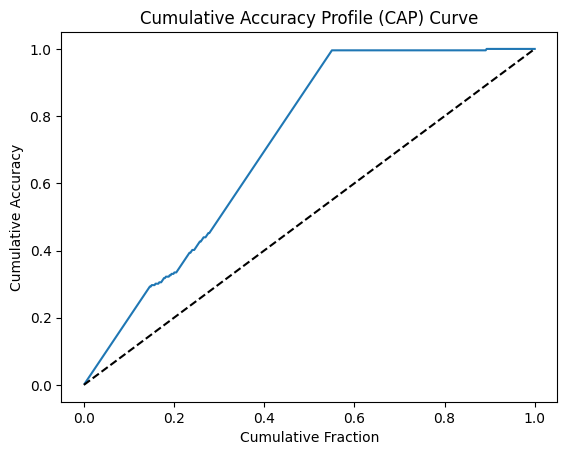

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the predicted probabilities or scores named 'predicted_scores' and true labels named 'true_labels'

# Sort the scores and corresponding true labels
sorted_indices = np.argsort(y_pred_cv)[::-1]
sorted_true_labels = y_resampled[sorted_indices]

# Calculate cumulative metrics
total_positive = np.sum(y_resampled)
cumulative_positives = np.cumsum(sorted_true_labels)
cumulative_accuracy = cumulative_positives / total_positive
cumulative_fraction = np.arange(1, len(sorted_true_labels) + 1) / len(sorted_true_labels)

# Create the CAP curve plot
plt.plot(cumulative_fraction, cumulative_accuracy, label='Model')
plt.plot([0, 1], [0, 1], 'k--', label='Baseline')
plt.xlabel('Cumulative Fraction')
plt.ylabel('Cumulative Accuracy')
plt.title('Cumulative Accuracy Profile (CAP) Curve')

## Feature Importance

In [62]:
# drop last column
dataset= dataset.drop(['classification'], axis=1)

# Fit the logistic regression model
classifier.fit(X_resampled, y_resampled)

# Modify the get_feature_names_out function to exclude 'remainder__'
def get_feature_names_without_prefix(transformer, input_features=None):
    return [f.split('remainder__')[-1] for f in transformer.get_feature_names_out(input_features)]

# Get the feature names without 'remainder__' prefix
feature_names = get_feature_names_without_prefix(ct, input_features=dataset.columns)

# Get the coefficients and feature names
coefficients = classifier.coef_[0]

# Create a DataFrame to display coefficients and feature names
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the coefficients by magnitude
coefficients_df['Abs_Coefficient'] = np.abs(coefficients_df['Coefficient'])
coefficients_df = coefficients_df.sort_values(by='Abs_Coefficient', ascending=False)

# Print the feature names and coefficients
print("Top features and their coefficients:")
print(coefficients_df.head(5))




Top features and their coefficients:
                Feature  Coefficient  Abs_Coefficient
64  min_time_per_gamble   -22.340998        22.340998
39              max_p/b    18.700845        18.700845
35            min_wager   -17.328842        17.328842
26        ave_slotdenom    16.319888        16.319888
21           last_wager    14.723203        14.723203


### Double Check

In [63]:
# Fit the logistic regression model
classifier.fit(X_resampled, y_resampled)

# Extract feature coefficients (importance)
feature_importance = classifier.coef_[0]

# Map feature names to coefficients
feature_names = ct.get_feature_names_out()
coefs_with_names = list(zip(feature_names, feature_importance))

# Sort coefficients by magnitude (absolute value) in descending order
coefs_with_names.sort(key=lambda x: abs(x[1]), reverse=True)

# Print feature importance
print("Feature Importance (Top features with highest absolute coefficients):")
for feature, coef in coefs_with_names:
    print(f"{feature}: {coef}")

Feature Importance (Top features with highest absolute coefficients):
remainder__x51: -22.34099795932672
remainder__x26: 18.700844673593462
remainder__x22: -17.3288418589758
remainder__x13: 16.31988820762241
remainder__x8: 14.723202809380378
remainder__x25: -12.092611495585462
remainder__x5: -12.025360641802601
remainder__x16: -10.593481028803964
encoder__x3_night: -10.095090331086906
remainder__x37: 9.912004729602756
encoder__x4_gain: 8.064370452908411
remainder__x43: 6.631038588403389
remainder__x9: -5.668044409225384
remainder__x6: -5.4592604135398926
encoder__x1_Gen Z: -4.253728626851842
remainder__x10: 4.138914458647443
remainder__x28: -4.1335870906163334
encoder__x7_gain: 4.1143108450218975
encoder__x3_evening: -4.040404161557644
remainder__x34: -3.6421169767663346
remainder__x46: -2.9718036963734153
encoder__x3_morning: 2.800075760999588
encoder__x4_near-hit: -2.2971131019142055
remainder__x33: 2.284345347984468
encoder__x1_Millenials: 2.221015977889908
remainder__x17: -2.160600